# Imports

In [ ]:
%load_ext autoreload
%autoreload 2

In [78]:
import sys

sys.path.append("..")

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import seaborn as sns

from model.edl import EDLClassifier, TypeIIMaximumLikelihoodLoss, CEBayesRiskLoss, SSBayesRiskLoss, KLDivergenceLoss

# Read some data

In [170]:
# change to CPU if you don't run on a mac and don't have a GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 256
training_data = datasets.MNIST(
    root="../data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.MNIST(
    root="../data",
    train=False,
    download=True,
    transform=ToTensor(),
)

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"{training_data[0][0].size()=}")
print(f"{training_data[0][1]=}")

print(f"{len(train_dataloader)=}")
print(f"{len(test_dataloader)=}")

training_data[0][0].size()=torch.Size([1, 28, 28])
training_data[0][1]=5
len(train_dataloader)=235
len(test_dataloader)=40


# Train and evaluate the model

In [171]:
# define a simple encoder for image modality      
# output is of shape (batch, 50, 4, 4)
encoder = nn.Sequential(
    nn.Conv2d(1, 20, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(20, 50, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2)
)
model = EDLClassifier(encoder, dim_encoder_out=50 * 4 * 4, dim_hidden=500, num_classes=10, dropout=0.2)
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"{num_trainable_params=}")

num_trainable_params=431070


In [182]:
max_epoch = 4

bayes_risk = SSBayesRiskLoss()
kld_loss = KLDivergenceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.005)
batch_losses = []

model.to(device)
model.train()

for epoch in range(max_epoch):
    for i, (x, labels) in enumerate(iter(train_dataloader)):
        # the loss expects the target to be one-hot encoded
        eye = torch.eye(10, dtype=torch.float32, device=device)
        labels = eye[labels]
        evidences = model(x)
        
        annealing_coef = min(1.0, epoch / max_epoch)
        loss = bayes_risk(evidences, labels) + annealing_coef * kld_loss(evidences, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        batch_losses.append(loss.cpu().item())
        
        print(f"Epoch {epoch + 1:02d} - batch {i + 1}/{len(train_dataloader)} - loss: {loss.cpu().item():.3f}", end="\r",)
    print("")

Epoch 01 - batch 235/235 - loss: 0.117
Epoch 02 - batch 235/235 - loss: 0.207
Epoch 03 - batch 235/235 - loss: 0.212
Epoch 04 - batch 235/235 - loss: 0.167


In [183]:
model.eval()

predictions, uncertainty, beliefs, labels = [], [], [], []
for x, y in iter(test_dataloader):
    y_pred, u, b = model.predict(x)
    labels.append(y)
    predictions.append(y_pred)
    uncertainty.append(u)
    beliefs.append(b)

labels = torch.concat(labels, dim=0)
predictions = torch.concat(predictions, dim=0)
uncertainty = torch.concat(uncertainty, dim=0)
beliefs = torch.concat(beliefs, dim=0)

accuracy = torch.sum(torch.argmax(predictions, dim=-1) == labels) / len(test_data)

print(f"{accuracy=:.2%}")

accuracy=97.39%


<Axes: ylabel='Count'>

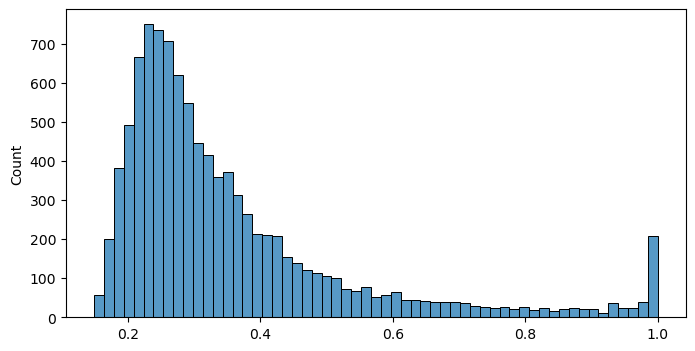

In [184]:
# Plot model uncertainty on the test set. We see that the mass is on the left which means the model is rather confident
# nevertheless we do see a mode around 1 for samples where the model was not able to gather evidence about their classes
fig, ax = plt.subplots(figsize=(8, 4))
sns.histplot(uncertainty.numpy().ravel(), ax=ax)

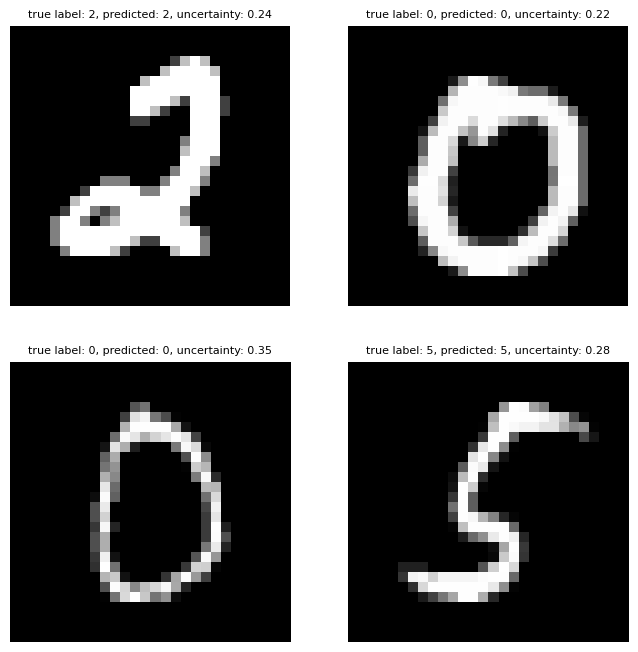

In [185]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 2, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    img, label = test_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(
        f"true label: {label}, predicted: {predictions.argmax(dim=-1)[sample_idx]}, uncertainty: {uncertainty[sample_idx].item():.2f}", 
        fontsize=8
    )
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()